# Notebook 02 — Execution Quality Analysis

This notebook performs a **transaction cost analysis (TCA)** of a single simulation run. Where Notebook 01 focuses on headline PnL and inventory, this notebook opens the hood and asks *why* results look the way they do at the level of individual fills.

| Section | Question answered |
|---------|------------------|
| 1 — Maker/Taker Mix & Fee Drag | How much of the volume is passive (maker) vs. aggressive (taker)? What is the net fee impact? |
| 2 — Slippage Proxy | Are fills happening at prices close to the contemporaneous mid, or are we paying a large implicit cost? |
| 3 — Adverse Selection & Realized Spread | After each fill, does the price move in our favour or against us? How much of our quoted spread do we actually keep? |

**Data source:** `outputs/baseline_mm_result.json` — same file as Notebook 01. Re-run `make report` to refresh.

---

### TCA in real markets vs. this simulator

In production, TCA compares execution prices against a **benchmark** (typically arrival mid, VWAP, or implementation shortfall). Here we use the contemporaneous mid price and a fixed look-ahead horizon as our benchmarks — simpler, but sufficient to diagnose whether the fill model and strategy parameters are well-calibrated.

## How to use this notebook

1. Ensure `outputs/baseline_mm_result.json` exists (run `make report` or `PYTHONPATH=src python scripts/run_backtest.py --config configs/baseline_mm.json --output outputs/baseline_mm_result.json`).
2. **Run All Cells** top-to-bottom. The parameters cell below sets the path; change it to point at any other result file.
3. Compare results against the benchmarks in the interpretation notes at the end of each section.

### Papermill usage
```bash
papermill notebooks/02_execution_quality_analysis.ipynb outputs/nb02_run.ipynb \
    -p result_json outputs/my_other_run.json
```

In [1]:
# Parameters (override with papermill -p result_json <path>)
result_json = '../outputs/baseline_mm_result.json'

In [2]:
from __future__ import annotations

import json
from pathlib import Path

import matplotlib.pyplot as plt

result_path = Path(result_json)
if not result_path.exists():
    raise FileNotFoundError(f'Missing {result_json}. Run `make report` first.')

with result_path.open('r', encoding='utf-8') as f:
    payload = json.load(f)

summary = payload['summary']
series  = payload['series']
fills   = payload['fills']
mid     = series['mid']

print('=== Simulation Summary ===')
for k, v in summary.items():
    print(f'  {k:<35s}: {v:,.6f}' if isinstance(v, float) and v != float('inf') else f'  {k:<35s}: {v}')

=== Simulation Summary ===
  final_pnl                          : -3.386662
  max_drawdown                       : -21.072702
  sharpe_annualized                  : -2.485023
  fills                              : 369.000000
  fees_paid                          : -1.139106
  avg_abs_inventory                  : 6.078160
  inventory_half_life                : inf
  fill_rate                          : 0.147600
  realized_spread_avg                : 0.033989
  adverse_selection_avg              : 0.003553


## 1) Maker/taker mix and fee drag

### Maker vs. taker in limit-order markets

Every fill in a limit-order market is classified as either **maker** (passive, liquidity-providing) or **taker** (aggressive, liquidity-consuming):

- A **maker** order rests in the book and waits to be hit. It provides liquidity and earns a **rebate** (negative fee) from the exchange, because the exchange wants deep books.
- A **taker** order crosses the spread to hit a resting order immediately. It consumes liquidity and pays a **fee** to the exchange.

In this simulator, fee sign infers the role:
```python
fee < 0  →  maker fill  (rebate received)
fee > 0  →  taker fill  (fee paid)
```

### `InventorySkewMM` is a pure maker strategy

The baseline strategy only places passive limit orders — it never crosses the spread. You should therefore see `taker_count = 0`. Any taker fills would indicate the strategy is also sending aggressive orders (e.g. `MomentumStrategy` or `TWAPStrategy`).

### Fee drag interpretation

Maker rebates accumulate as negative `fees_paid`. A larger rebate (more negative) means more passive volume, which is generally desirable for a market maker. However, high rebate volume with poor PnL signals that adverse selection losses are swamping the rebate income.

> **Rule of thumb:** if `|fees_paid| < |max_drawdown|`, fee drag alone cannot explain the PnL loss — look to adverse selection and inventory risk instead.

In [3]:
maker_count = 0
taker_count = 0
maker_notional = 0.0
taker_notional = 0.0
maker_fee = 0.0
taker_fee = 0.0

for f in fills:
    notional = f['price'] * f['size']
    if f['fee'] <= 0.0:
        maker_count += 1
        maker_notional += notional
        maker_fee += f['fee']
    else:
        taker_count += 1
        taker_notional += notional
        taker_fee += f['fee']

print('maker_count:', maker_count)
print('taker_count:', taker_count)
print('maker_notional:', round(maker_notional, 4))
print('taker_notional:', round(taker_notional, 4))
print('maker_fee (rebate if negative):', round(maker_fee, 6))
print('taker_fee:', round(taker_fee, 6))
print('net_fee:', round(maker_fee + taker_fee, 6))

maker_count: 369
taker_count: 0
maker_notional: 22782.1116
taker_notional: 0.0
maker_fee (rebate if negative): -1.139106
taker_fee: 0.0
net_fee: -1.139106


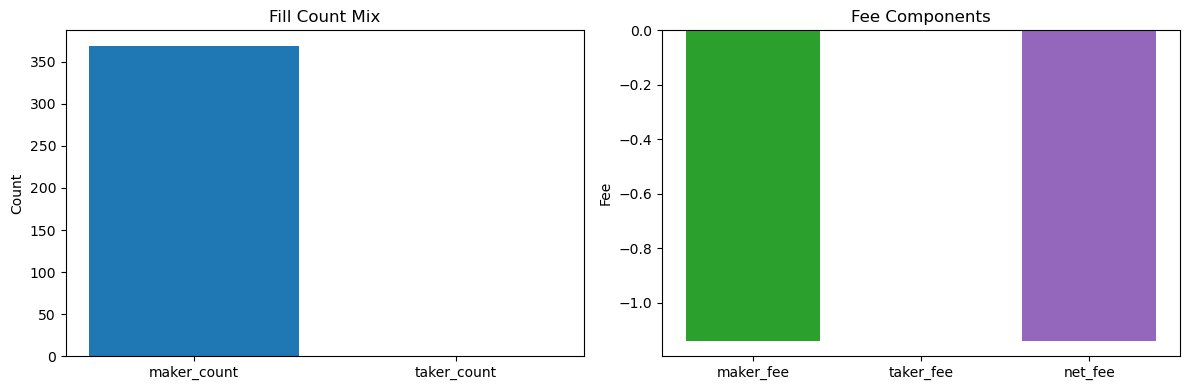

In [4]:
labels = ['maker_count', 'taker_count']
values = [maker_count, taker_count]

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].bar(labels, values, color=['tab:blue', 'tab:orange'])
ax[0].set_title('Fill Count Mix')
ax[0].set_ylabel('Count')

fee_labels = ['maker_fee', 'taker_fee', 'net_fee']
fee_values = [maker_fee, taker_fee, maker_fee + taker_fee]
ax[1].bar(fee_labels, fee_values, color=['tab:green', 'tab:red', 'tab:purple'])
ax[1].set_title('Fee Components')
ax[1].set_ylabel('Fee')

plt.tight_layout()
plt.show()

## 2) Slippage proxy analysis

### What is slippage?

**Slippage** is the difference between the price you expected to trade at (the benchmark) and the price you actually traded at. For a passive market maker the natural benchmark is the **contemporaneous mid price**: we placed our bid below mid and our ask above mid, so we expect fills to occur *inside* the mid.

Signed slippage is defined here as:

```
slippage = fill_price − mid(t)          [for a buy fill]
slippage = mid(t) − fill_price          [for a sell fill]
```

A **negative** value means we filled at a better price than mid — the expected outcome for a passive maker (our bid is below mid, so `fill_price < mid`, giving negative slippage). Positive slippage on a passive fill would be a bug.

### Interpreting the histogram

- The entire distribution should sit **left of zero** for a pure maker strategy.
- The mean slippage magnitude should be approximately `half_spread_bps × mid / 10000` — the half-spread we quoted.
- A distribution centred close to zero suggests quotes are placed very near the mid (narrow half-spread); spread further left reflects a wider quoted half-spread.
- **Outliers far left**: fills happened during a stressed period when the spread was unusually wide (vol-dependent widening), producing a large favourable price vs. mid.

> Note: this is a *proxy*, not a true implementation-shortfall measure. In practice, slippage is computed against the arrival mid (mid at order submission), which requires order-level timestamps not present in this output format.

avg_slippage: -0.03043596


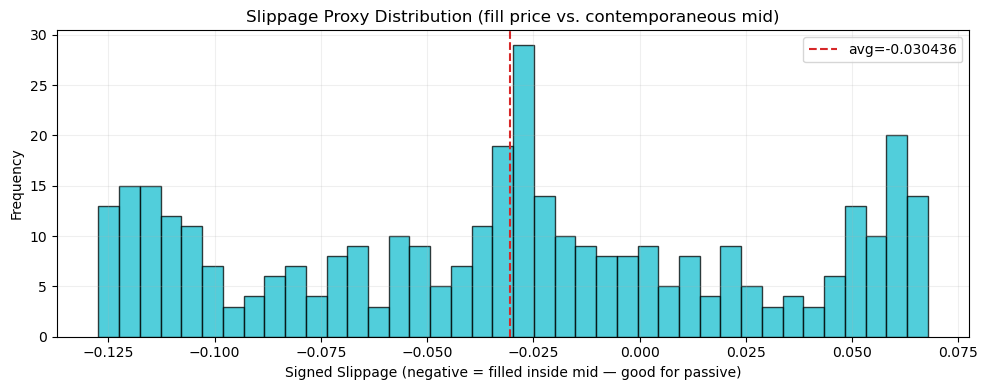

In [5]:
# Slippage proxy: fill price vs. contemporaneous mid.
# buy: fill_price - mid (positive = paid above mid, worse)
# sell: mid - fill_price (positive = received below mid, worse)
slippage = []
for f in fills:
    step = f['step']
    if not (0 <= step < len(mid)):
        continue
    m = mid[step]
    s = (f['price'] - m) if f['side'] == 'buy' else (m - f['price'])
    slippage.append(s)

avg_slippage = sum(slippage) / len(slippage) if slippage else 0.0
print(f'avg_slippage: {avg_slippage:.8f}')

fig, ax = plt.subplots(figsize=(10, 4))
ax.hist(slippage, bins=40, color='tab:cyan', edgecolor='black', alpha=0.75)
ax.axvline(avg_slippage, color='tab:red', linestyle='--', label=f'avg={avg_slippage:.6f}')
ax.set_title('Slippage Proxy Distribution (fill price vs. contemporaneous mid)')
ax.set_xlabel('Signed Slippage (negative = filled inside mid — good for passive)')
ax.set_ylabel('Frequency')
ax.legend()
ax.grid(alpha=0.2)
plt.tight_layout()
plt.show()

## 3) Adverse selection cost and realized spread

### The core microstructure trade-off

Every time a passive market-maker order is filled, two futures are possible:

1. **Uninformed flow**: the counterparty had no special information. The mid price stays near where it was. The MM earns roughly the half-spread it quoted. ✅
2. **Informed flow (adverse selection)**: the counterparty knew the price was about to move. After filling, the mid drifts in the direction of their trade — *away* from the MM's position. The MM took on a losing trade. ❌

The **adverse selection cost** quantifies outcome (2). It is measured by looking at how much the mid price moved *after* each fill, over a fixed horizon (`adverse_selection_horizon` steps):

```
For a passive buy fill:
    mid_after > mid_before  →  price rose  →  we were not adversely selected (positive cost)
    mid_after < mid_before  →  price fell  →  we were adversely selected    (negative cost)

For a passive sell fill:
    mid_after < mid_before  →  price fell  →  we were not adversely selected (positive cost)
    mid_after > mid_before  →  price rose  →  we were adversely selected    (negative cost)
```

### The spread decomposition identity

These three quantities satisfy an exact accounting identity:

```
Quoted half-spread  =  Realized half-spread  +  Adverse selection cost

For a buy fill:
  (mid_before − fill_price)  =  (mid_after − fill_price)  +  (mid_before − mid_after)
```

The **realized spread** is what we actually captured from providing liquidity. The **adverse selection cost** is what we gave back because the price moved against us. Their sum must equal the quoted half-spread by construction.

### What the three histograms show

| Histogram | What to look for |
|-----------|-----------------|
| **Adverse Selection Cost** | Centred near zero (random uninformed flow) or shifted negative (informed flow). Large negative mean → widen quotes. |
| **Realized Half-Spread** | Should be positive on average. If negative, adverse selection exceeds the quoted spread — the strategy is systematically losing on each fill. |
| **Quoted Half-Spread** | Should match `half_spread_bps × mid / 10000`. Variation reflects inventory-skew adjustments and vol-dependent spread widening. |

### Model limitations

- The look-ahead horizon is **fixed** (`adverse_selection_horizon` in config). Short horizons underestimate permanent impact; long horizons conflate adverse selection with unrelated price drift.
- In production TCA, post-trade price impact is modelled as a function of trade size and market conditions, not a fixed window.
- This simulator does not model **queue position** — in a real LOB, fills only happen once all higher-priority orders at the same price are exhausted. Queue position is a major determinant of adverse selection severity.

passive fills          : 369
avg adverse_sel_cost   : 0.003553
avg realized_spread    : 0.033989
avg quoted_half_spread : 0.030436
identity check (qs≈rs+as): 0.030436 ≈ 0.037542


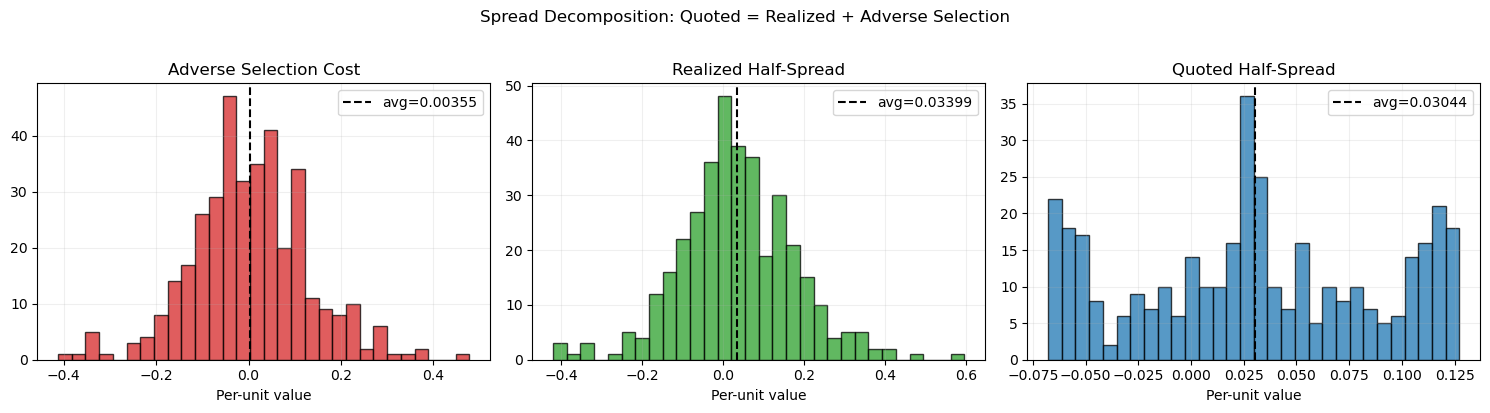

In [6]:
# ── Adverse selection & realized spread (engine-computed) ──────────────
passive_fills = [f for f in fills if f.get('mid_before', 0.0) != 0.0]

if passive_fills:
    as_costs = [f['adverse_selection_cost'] for f in passive_fills]
    rs_vals  = [f['realized_spread']        for f in passive_fills]
    qs_vals  = [f.get('mid_before', f['price']) - f['price']
                if f['side'] == 'buy'
                else f['price'] - f.get('mid_before', f['price'])
                for f in passive_fills]

    avg_as = sum(as_costs) / len(as_costs)
    avg_rs = sum(rs_vals)  / len(rs_vals)
    avg_qs = sum(qs_vals)  / len(qs_vals)

    print(f'passive fills          : {len(passive_fills)}')
    print(f'avg adverse_sel_cost   : {avg_as:.6f}')
    print(f'avg realized_spread    : {avg_rs:.6f}')
    print(f'avg quoted_half_spread : {avg_qs:.6f}')
    print(f'identity check (qs≈rs+as): {avg_qs:.6f} ≈ {avg_rs + avg_as:.6f}')

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    for ax, data, label, color in zip(
        axes,
        [as_costs, rs_vals, qs_vals],
        ['Adverse Selection Cost', 'Realized Half-Spread', 'Quoted Half-Spread'],
        ['tab:red', 'tab:green', 'tab:blue'],
    ):
        ax.hist(data, bins=30, color=color, alpha=0.75, edgecolor='black')
        ax.axvline(sum(data)/len(data), color='black', linestyle='--',
                   label=f'avg={sum(data)/len(data):.5f}')
        ax.set_title(label)
        ax.set_xlabel('Per-unit value')
        ax.legend()
        ax.grid(alpha=0.2)
    plt.suptitle('Spread Decomposition: Quoted = Realized + Adverse Selection', y=1.02)
    plt.tight_layout()
    plt.show()
else:
    print('No passive fills with mid_before set — re-run backtest with new engine.')


## Caveats and model scope

### What this simulator captures well
- **Inventory risk** from one-sided fill accumulation
- **Spread decomposition** via the Glosten-Milgrom identity (realized spread + adverse selection = quoted half-spread)
- **Regime-dependent behaviour**: wider spreads and higher fill rates during stressed periods
- **Fee economics**: maker rebate vs. taker fee trade-off across strategies

### What is intentionally simplified
| Simplification | Real-world equivalent |
|---------------|----------------------|
| Fixed fill probability per step | Actual queue position, depth, and order size determine fill likelihood |
| Binary regime (calm/stressed) | Continuous volatility surface; GARCH / stochastic vol models |
| Fixed look-ahead for adverse selection | Calibrated price-impact decay curves (Kyle λ, Almgren-Chriss) |
| No market impact from our own orders | Our quotes move the book; large orders shift the mid |
| Single instrument, no correlation | Multi-asset MMs hedge inventory across correlated names |

### Extending this framework
- **Parameter sweep**: run `scripts/run_backtest.py` across a grid of `half_spread_bps` and `inv_penalty_bps` values, then plot the efficient frontier (Sharpe vs. avg |inventory|) across configs.
- **Other strategies**: swap `"type": "InventorySkewMM"` in the config for `"TWAPStrategy"` or `"MomentumStrategy"` and compare execution quality metrics here.
- **Longer horizons**: increase `adverse_selection_horizon` to see how persistent price impact is in the simulated market.
- **Stressed-only runs**: set `calm_to_stressed_prob: 1.0` to simulate a crisis regime and see how the MM behaves under sustained high volatility.